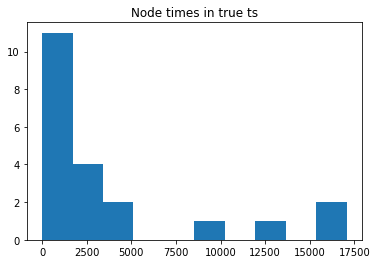

1592 mutations


In [1]:
import tsinfer
import msprime
import tskit
import tsdate

import numpy as np
import matplotlib.pyplot as plt

Ne = 10000
hist_time=5000
mu = 1e-8
rho = 0
samples = [
        msprime.SampleSet(1, time=hist_time, ploidy=1),
        msprime.SampleSet(5),
    ]
mutated_ts = msprime.sim_ancestry(
    samples=samples,
    population_size=Ne,
    sequence_length=2e6,
    recombination_rate=rho,
    random_seed=1,
)
mutated_ts = msprime.mutate(mutated_ts, rate=mu, random_seed=1)

plt.hist(mutated_ts.nodes_time)
plt.title("Node times in true ts")
plt.show()
print(mutated_ts.num_mutations, "mutations")

def create_sampledata_with_individual_times(ts):
    """
    The tsinfer.SampleData.from_tree_sequence function doesn't allow different time
    units for sites and individuals. This function adds individual times by hand
    """
    # sampledata file with times-as-frequencies
    sd = tsinfer.SampleData.from_tree_sequence(ts)
    # Set individual times separately - warning: this mixes time units
    # so that sites have TIME_UNCALIBRATED but individuals have meaningful times
    individual_time = np.full(sd.num_individuals, -1)
    for sample, node_id in zip(sd.samples(), ts.samples()):
        if individual_time[sample.individual] >= 0:
            assert individual_time[sample.individual] == ts.node(node_id).time
        individual_time[sample.individual] = ts.node(node_id).time
    assert np.all(individual_time >= 0)
    sd = sd.copy()
    sd.individuals_time[:] = individual_time
    sd.finalise()
    return sd

def set_times_for_historical_samples(ts):
    """
    Use the times stored in the individuals metadata of an inferred tree sequence
    to constrain the times.
    """
    tables = ts.dump_tables()
    tables.individuals.metadata_schema = tskit.MetadataSchema.permissive_json()
    ts = tables.tree_sequence()
    times = np.zeros(ts.num_nodes)
    # set sample node times of historic samples
    for node_id in ts.samples():
        individual_id = ts.node(node_id).individual
        if individual_id != tskit.NULL:
            times[node_id] = ts.individual(individual_id).metadata.get("sample_data_time", 0)
    # Just need to make the ts consistent
    constrained_times = tsdate.core.constrain_ages_topo(ts, times, eps=1e-1)
    tables.nodes.time = constrained_times
    tables.mutations.time = np.full(ts.num_mutations, tskit.UNKNOWN_TIME)
    tables.sort()
    return tables.tree_sequence()

In [2]:
#sampledata = create_sampledata_with_individual_times(mutated_ts)
#inferred_ts = tsinfer.infer(sampledata)
#inferred_ts_w_times = set_times_for_historical_samples(inferred_ts).simplify()

prior = tsdate.build_prior_grid(mutated_ts, Ne=Ne, allow_historical_samples=True, truncate_priors=True, node_var_override={0:1000})

In [3]:
# Make a uniform prior over all timeslices
prior[0] = np.concatenate(([0],np.diff(prior.timepoints)/np.max(np.diff(prior.timepoints))))
hist_prior = prior[0].copy()

In [4]:
# date
dated_ts, posteriors = tsdate.date(mutated_ts, priors=prior, mutation_rate=mu, return_posteriors=True)

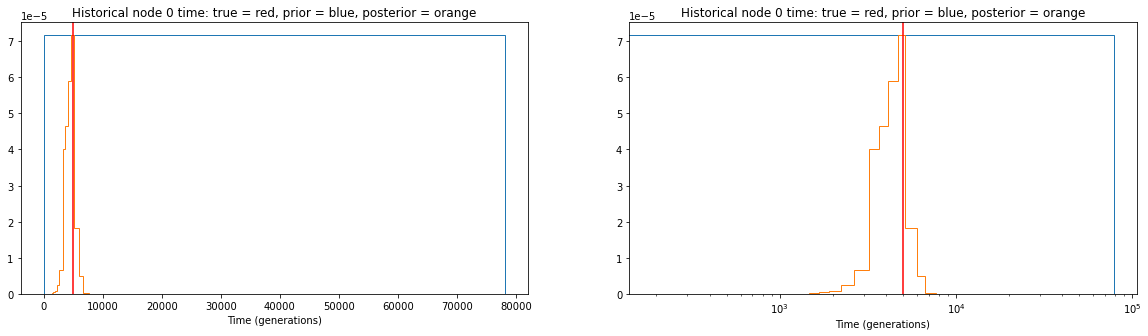

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
prior_pdf = hist_prior[1:]/np.diff(prior.timepoints)
max_prior = np.max(prior_pdf)
posterior_pdf = posteriors[0]/(posteriors['end_time'] - posteriors['start_time'])
for ax in axes:
    ax.stairs(prior_pdf, prior.timepoints)
    ax.stairs(posterior_pdf / max(posterior_pdf) * max_prior, np.concatenate((posteriors['start_time'][:1], posteriors['end_time'])))
    ax.axvline(hist_time, c="red")
    ax.set_title(f"Historical node 0 time: true = red, prior = blue, posterior = orange")
    ax.set_xlabel(f"Time ({dated_ts.time_units})")
axes[1].set_xscale("log")